In [6]:
import numpy as np
import random
import time
import pandas

from keras.callbacks import LambdaCallback

from keras import optimizers
from keras.layers import Activation, Input, LSTM, Dense, Dropout, BatchNormalization, GRU, Flatten, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

from pandas import read_csv
from socketIO_client import SocketIO, LoggingNamespace
from Audio.Components.MidiPlayer import MidiPlayer

from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

In [7]:
# socket = SocketIO('localhost', 9876, LoggingNamespace)
# from MidiPlayer import MidiPlayer
player = MidiPlayer()

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [8]:
dropout = 0.02
n_time_steps = 2
semi_redundancy_step = 3

In [9]:
corpus = read_csv('Audio/data/output.csv', header=1)
print(list(corpus))
print('corpus length:', len(corpus))

['0', ' 0.92', ' 18']
corpus length: 16


In [10]:
notes_index = corpus.values[:, 0]
length_index = corpus.values[:, 1]
print(note_index)
print(length_index)

NameError: name 'note_index' is not defined

In [11]:
# notes = sorted(list(set(notes_index)))
lengths = sorted(list(set(length_index)))
notes = []
for i in range(0, 128):
    notes.append(i)
    
print('num_events:', len(notes))
# print(notes)
note_index = dict((c, i) for i, c in enumerate(notes))
index_note = dict((i, c) for i, c in enumerate(notes))

lengths_index = dict((c, i) for i, c in enumerate(lengths))
index_lengths = dict((i, c) for i, c in enumerate(lengths))
print(lengths_index)
print(index_lengths)

num_events: 128
{0.05: 0, 0.09: 1, 0.33: 2, 0.51: 3, 0.6: 4, 0.65: 5, 0.84: 6, 0.93: 7, 0.98: 8, 1.3: 9, 1.4: 10}
{0: 0.05, 1: 0.09, 2: 0.33, 3: 0.51, 4: 0.6, 5: 0.65, 6: 0.84, 7: 0.93, 8: 0.98, 9: 1.3, 10: 1.4}


In [12]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(length_index[:].reshape(-1,1))
# length_index = scaler.transform(length_index[:].reshape(-1,1))
# print(length_index[0:3])

In [13]:
length_phrases = []
next_length = []
note_phrases = []
next_note = []
for i in range(0, len(notes_index) - n_time_steps, semi_redundancy_step):
    note_phrases.append(notes_index[i: i + n_time_steps])
    length_phrases.append(length_index[i: i + n_time_steps])
    
    next_note.append(notes_index[i + n_time_steps])
    next_length.append(length_index[i + n_time_steps])
print('nb sequences:', len(note_phrases))
# for i in range(2):
#     print('______________')
#     print('note_x', note_phrases[i])
#     print('note_y', next_note[i])
#     print('length_x', length_phrases[i])
#     print('length_y', next_length[i])
print(length_phrases)
print(next_length)

nb sequences: 5
[array([0.65, 0.51]), array([1.4 , 0.05]), array([0.6 , 0.33]), array([0.09, 0.98]), array([1.3 , 0.51])]
[1.3, 0.93, 0.33, 1.3, 1.3]


In [14]:
print('Vectorization...')

note_x = np.zeros((len(note_phrases), n_time_steps, len(notes)), dtype=np.bool)
note_y = np.zeros((len(note_phrases), len(notes)), dtype=np.bool)

length_x = np.zeros((len(length_phrases), n_time_steps, len(lengths)), dtype=np.bool)
length_y = np.zeros((len(length_phrases), len(lengths)), dtype=np.bool)

for i, phrase in enumerate(note_phrases):
    for t, note in enumerate(phrase):
        print(i, t, note)
        note_x[i, t, note_index[note]] = 1
    note_y[i, note_index[next_note[i]]] = 1

for i, phrase in enumerate(length_phrases):
    for t, length in enumerate(phrase):
        print(i, t, length)
        length_x[i, t, lengths_index[length]] = 1
    length_y[i, lengths_index[next_length[i]]] = 1
    
# print('______________')
# print('length_x', length_x[0])
# print('length_y', length_y[0])
# print('note_x', note_x[0])
# print('note_y', note_y[0])

Vectorization...
0 0 58.0
0 1 57.0
1 0 52.0
1 1 61.0
2 0 0.0
2 1 50.0
3 0 53.0
3 1 52.0
4 0 55.0
4 1 52.0
0 0 0.65
0 1 0.51
1 0 1.4
1 1 0.05
2 0 0.6
2 1 0.33
3 0 0.09
3 1 0.98
4 0 1.3
4 1 0.51


In [15]:
print(note_x.shape)
print(length_x.shape)
print(note_y.shape)
print(length_y.shape)

(5, 2, 128)
(5, 2, 11)
(5, 128)
(5, 11)


In [16]:
lstm_size = 64

note_input = Input(name='note_input', shape=(n_time_steps, len(notes)))
length_input = Input(name='length_input', shape=(n_time_steps, len(lengths)))

# input_merge = concatenate([note_input, length_input])

# nn = LSTM(lstm_size, return_sequences=True)(input_merge)
# # nn = Dropout(dropout)(nn)
# nn = LSTM(lstm_size, return_sequences=True)(nn)

note_branch = LSTM(lstm_size, return_sequences=True)(note_input)
note_share = LSTM(int(lstm_size/4), return_sequences=True)(note_branch)

length_branch = LSTM(lstm_size, return_sequences=True)(length_input)
length_share = LSTM(int(lstm_size/4), return_sequences=True)(length_branch)

length_merge = concatenate([length_branch, note_share])
note_merge = concatenate([note_branch, length_share])

length_lstm = LSTM(lstm_size, return_sequences=False)(length_merge)
note_lstm = LSTM(lstm_size, return_sequences=False)(note_merge)
                    
output_notes = Dense(len(notes), activation='softmax', name='note_output')(note_lstm)
length_output = Dense(len(lengths), activation='softmax', name='length_output')(length_lstm)

optimizer = optimizers.RMSprop(lr=0.001)
model = Model(inputs=[note_input, length_input], outputs=[output_notes, length_output])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 2, 128)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 2, 11)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 2, 64)        49408       note_input[0][0]                 
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 2, 64)        19456       length_input[0][0]               
__________________________________________________________________________________________________
lstm_4 (LS

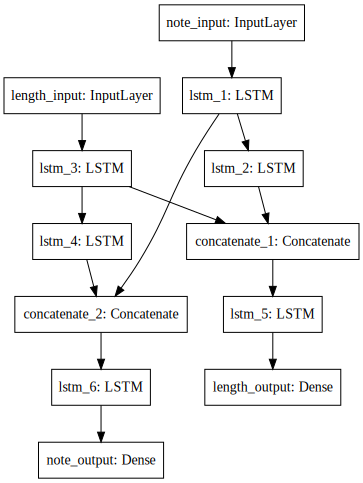

In [18]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [20]:
def midi_to_hertz(midi):
    if midi == 0:
        return 0
    g = 2**(1/12)
    return 440*g**(midi-69)

In [21]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch % 10 == 0 and epoch > -1:
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = 0
        for diversity in [1]:
            print('----- diversity:', diversity)

            generated_notes = []
            generated_length = []
            current_note_phrase = notes_index[start_index: start_index + n_time_steps]
            current_length_phrase = length_index[start_index: start_index + n_time_steps]
            generated_notes.extend(current_note_phrase)
            generated_length.extend(current_length_phrase)
    
            n_generated = 20
            start_time = time.time()
            for i in range(n_generated):
                x_pred = np.zeros((1, n_time_steps, len(notes)))
                length_x_pred = np.zeros((1, n_time_steps, len(lengths)))

                for t, event in enumerate(current_note_phrase):
                    x_pred[0, t, note_index[event]] = 1.

                for t, event in enumerate(current_length_phrase):
                    length_x_pred[0, t, lengths_index[event]] = 1

                pred = model.predict([x_pred, length_x_pred], verbose=0)
                note_pred = pred[0][0]
                length_pred = pred[1][0]
                
                note_index_from_sample = sample(note_pred, diversity)
                note_prediction = index_note[note_index_from_sample]
                
                length_index_from_sample = sample(length_pred, diversity)
                length_prediction = index_lengths[length_index_from_sample]
                
#                 print(note_prediction)
#                 print(length_prediction)
                
                generated_notes.append(note_prediction)
                generated_length.append(length_prediction)
                
                current_note_phrase = np.append(current_note_phrase[1:], note_prediction)
                current_length_phrase = np.append(current_length_phrase[1:], length_prediction)
                
                end_time = time.time()
            counter = 0
            for i in range(len(generated_notes)):
                note = generated_notes[i]
                length = generated_length[i]
#                 freq = midi_to_hertz(note)
                print(note, '|', length)
                print('generated')
                player.play(note, length, 100)
#                     socket.emit('freq_change', {'freq': 4000, 'vol': 100})
                time.sleep(0.03)

                #socket.emit('freq_change', {'freq': freq, 'vol': 100})
                time.sleep(length * .5)


            #socket.emit('freq_change', {'freq': 0, 'vol': 100})

In [22]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit([note_x, length_x], [note_y, length_y],
          batch_size=256,
          epochs=1000,
          callbacks=[print_callback]
        )

Epoch 1/1000
----- Generating text after Epoch: 0
----- diversity: 1
58.0 | 0.65
generated
57.0 | 0.51
generated
0 | 0.65
generated
42 | 0.09
generated
49 | 0.33
generated
3 | 0.65
generated
127 | 0.09
generated
52 | 0.93
generated
65 | 0.33
generated
14 | 0.05
generated
97 | 0.98
generated
28 | 1.3
generated
122 | 1.3
generated
121 | 0.6
generated
23 | 1.4
generated
53 | 0.65
generated
25 | 0.05
generated
72 | 0.33
generated
96 | 0.98
generated
89 | 0.93
generated
109 | 0.65
generated
106 | 0.84
generated
5/5 [==============================] - 25s 5s/step - loss: 7.2510 - note_output_loss: 4.8533 - length_output_loss: 2.3977
Epoch 2/1000
5/5 [==============================] - 0s 3ms/step - loss: 7.2071 - note_output_loss: 4.8355 - length_output_loss: 2.3717
Epoch 3/1000
5/5 [==============================] - 0s 3ms/step - loss: 7.1731 - note_output_loss: 4.8216 - length_output_loss: 2.3515
Epoch 4/1000
5/5 [==============================] - 0s 3ms/step - loss: 7.1407 - note_output_los

Epoch 44/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.4945 - note_output_loss: 1.7823 - length_output_loss: 0.7122
Epoch 45/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.4474 - note_output_loss: 1.7534 - length_output_loss: 0.6940
Epoch 46/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.4045 - note_output_loss: 1.7289 - length_output_loss: 0.6756
Epoch 47/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3648 - note_output_loss: 1.7076 - length_output_loss: 0.6572
Epoch 48/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3277 - note_output_loss: 1.6892 - length_output_loss: 0.6385
Epoch 49/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.2926 - note_output_loss: 1.6730 - length_output_loss: 0.6196
Epoch 50/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.2592 - note_output_loss: 1.6587 - length_output_loss: 0.6004
Epoch 51/1000
----- Generating text after Epoch:

KeyboardInterrupt: 

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')